# Declaration of Originality

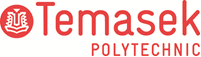

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Tan Wen Jun (2400845J)
* Tutorial Group                : C24B04
* Tutor						    : Mr. Emile Sabastian
* Submission Date               : 11/2/2026


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# 🌟 Stellar Object Classification — SDSS Dataset
## Sloan Digital Sky Survey: Classifying Stars, Galaxies & Quasars

**Dataset:** 100,000 astronomical observations  
**Task:** Multi-class Classification — STAR | GALAXY | QSO  
**Modelling library:** scikit-learn (only)  

---
## Section 1: Business Understanding

### What Problem Are We Solving?

Every night, the **Sloan Digital Sky Survey (SDSS)** records hundreds of thousands of new light sources across the sky. Each detection is described by its brightness across five photometric wavelength bands and its spectroscopic redshift. Before any scientific analysis can begin, astronomers must resolve a foundational question: **is this object a star, a galaxy, or a quasar?**

Historically, this classification was done manually by expert reviewers or through rigid, hand-crafted rule sets. These approaches cannot scale. The upcoming **Vera C. Rubin Observatory (LSST)** is projected to generate over 10 million transient alerts per night alone — a volume that makes human-driven classification operationally impossible.

### The Machine Learning Outcome

We build a **supervised multi-class classifier** that takes an SDSS observation's photometric and spectral measurements as input and outputs a predicted object class — STAR, GALAXY, or QSO. The model is trained on 80,000 labelled historical observations and validated on 20,000 held-out examples. The final trained model is exported and integrated into a live web application for real-time classification.

### Why Does This Matter to the Astronomy Community?

Accurate automated classification creates compounding value across the entire research pipeline:

**1. Cosmological mapping and dark energy research**  
Galaxies and quasars at precisely known redshifts are the tracers used to reconstruct the 3-D large-scale structure of the universe. Misclassifying galaxies degrades these maps, corrupting constraints on dark matter distributions, cosmic filaments, and the equation of state of dark energy. Every correct galaxy classification is a data point in humanity's understanding of why the universe's expansion is accelerating.

**2. Quasar science — preserving irreplaceable probes**  
Quasars are among the most energetic phenomena known — supermassive black holes actively consuming material at cosmological distances. Their light passes through billions of light-years of intergalactic gas, imprinting absorption signatures that reveal the composition, temperature, and structure of matter across cosmic time. A quasar misclassified as a star is silently discarded from these analyses. Our classifier must recall quasars with high sensitivity even though they are a minority class (~20% of observations).

**3. Stellar population and Milky Way structure studies**  
Studies of stellar chemistry, ages, and kinematics require a clean, uncontaminated stellar catalogue. Extragalactic objects leaking into stellar samples skew metallicity distributions and stellar age estimates. Precise star-galaxy separation is a prerequisite for any Milky Way structure analysis.

**4. Telescope time allocation**  
Spectroscopic follow-up — the expensive, time-limited step that yields precise redshifts and chemical abundances — is prioritised from photometric pre-classification. A high-precision classifier ensures that finite telescope hours are directed at the most scientifically valuable targets, not wasted confirming obvious objects or chasing misidentified ones.

**5. Foundation for next-generation surveys**  
A validated ML pipeline trained on SDSS establishes a transferable template for Euclid, DESI, and LSST — surveys that will collectively observe billions of objects. Algorithmic classification infrastructure built now directly enables the scientific output of the next decade of astronomy.

### Evaluation Metric Justification

We use **macro-averaged F1-score** as our primary metric. The dataset is moderately imbalanced (~59% galaxy, ~21% star, ~20% quasar). Raw accuracy would be dominated by galaxy performance — a classifier predicting "galaxy" for every observation achieves ~59% accuracy while completely failing on stars and quasars. Macro-F1 weights precision and recall **equally across all three classes**, directly reflecting the scientific requirement that no object type be systematically neglected. A high macro-F1 score means the model is reliably correct for stars, galaxies, and rare quasars alike.

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 1 — Global Imports & Reproducibility
#
# All modelling uses scikit-learn exclusively (no XGBoost, LightGBM, etc.).
# RANDOM_STATE = 42 seeds every stochastic step so results are fully
# reproducible: same split, same tree initialisation, same search order.
# ─────────────────────────────────────────────────────────────────────────────
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import joblib
import json

# scikit-learn — ONLY library used for modelling
from sklearn.model_selection  import train_test_split, RandomizedSearchCV
from sklearn.preprocessing    import LabelEncoder, StandardScaler
from sklearn.ensemble         import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model     import LogisticRegression
from sklearn.pipeline         import Pipeline
from sklearn.metrics          import (classification_report, confusion_matrix,
                                       f1_score, accuracy_score, ConfusionMatrixDisplay)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('dark_background')
PALETTE = {'GALAXY': '#4FC3F7', 'STAR': '#FFD54F', 'QSO': '#EF9A9A'}

print(f'✅ Libraries loaded | RANDOM_STATE = {RANDOM_STATE}')

✅ Libraries loaded | RANDOM_STATE = 42


---
## Section 2: Data Understanding

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2a — Load Dataset
# ─────────────────────────────────────────────────────────────────────────────
df = pd.read_csv('star_classification.csv')
print(f'Shape: {df.shape}  ({df.shape[0]:,} rows × {df.shape[1]} columns)')
df.head()

Shape: (100000, 18)  (100,000 rows × 18 columns)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2b — Variable Types and Roles
#
# Each column is assigned a role:
#   IDENTIFIER  — observatory bookkeeping; no predictive value
#   POSITIONAL  — sky coordinates
#   PHOTOMETRIC — spectral measurements (our primary features)
#   TARGET      — class label to predict
#
# Annotating roles here guides feature dropping decisions in Section 4.
# ─────────────────────────────────────────────────────────────────────────────
role_map = {
    'obj_ID'     : 'Identifier  — unique object ID (arbitrary integer)',
    'alpha'      : 'Positional  — Right Ascension angle (J2000)',
    'delta'      : 'Positional  — Declination angle (J2000)',
    'u'          : 'Photometric — Ultraviolet filter magnitude',
    'g'          : 'Photometric — Green filter magnitude',
    'r'          : 'Photometric — Red filter magnitude',
    'i'          : 'Photometric — Near-Infrared filter magnitude',
    'z'          : 'Photometric — Infrared filter magnitude',
    'run_ID'     : 'Identifier  — scan run number',
    'rerun_ID'   : 'Identifier  — image reprocessing number',
    'cam_col'    : 'Identifier  — camera column within scan',
    'field_ID'   : 'Identifier  — field number within scan',
    'spec_obj_ID': 'Identifier  — ⚠️ LEAKAGE RISK: same ID = same class (per dataset spec)',
    'class'      : 'TARGET      — GALAXY / STAR / QSO',
    'redshift'   : 'Spectral    — redshift z (wavelength stretch proxy for distance)',
    'plate'      : 'Identifier  — spectroscopic plate ID',
    'MJD'        : 'Identifier  — Modified Julian Date of observation',
    'fiber_ID'   : 'Identifier  — fibre pointing to focal plane',
}
type_df = pd.DataFrame({'Column': df.columns, 'dtype': df.dtypes.values,
                         'Role': [role_map[c] for c in df.columns]})
print(type_df.to_string(index=False))

     Column   dtype                                                                   Role
     obj_ID float64                     Identifier  — unique object ID (arbitrary integer)
      alpha float64                            Positional  — Right Ascension angle (J2000)
      delta float64                                Positional  — Declination angle (J2000)
          u float64                             Photometric — Ultraviolet filter magnitude
          g float64                                   Photometric — Green filter magnitude
          r float64                                     Photometric — Red filter magnitude
          i float64                           Photometric — Near-Infrared filter magnitude
          z float64                                Photometric — Infrared filter magnitude
     run_ID   int64                                          Identifier  — scan run number
   rerun_ID   int64                                Identifier  — image reprocessing number

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2c — Missing Data Check
#
# Normal astronomical outliers won't be removed as they are real phenomena (e.g. quasars with extreme colours). 
# ─────────────────────────────────────────────────────────────────────────────
print(df.isnull().sum())
missing = df.isnull().sum()
if missing.sum() == 0:
    print('✅ No missing values in any column.')
else:
    print(missing[missing > 0])

# ── Check for sentinel values (-9999 meaning "measurement failed")
# SDSS uses -9999 as a sentinel for missing/failed photometric measurements.
# These are NOT NaN so isnull() misses them.
print('\nSentinel value check (values < -100 = failed measurement):')
sentinel_found = False
for col in ['u', 'g', 'r', 'i', 'z']:
    n = (df[col] < -100).sum()
    if n > 0:
        print(f'  {col}: {n} sentinel values ({df[col].min():.0f})')
        sentinel_found = True
if not sentinel_found:
    print('  None found.')
else:
    print('\n⚠️  IMPLICATION: These rows will be removed in data preparation.')
    print('  Sentinel values would corrupt feature engineering (colour indices)')
    print('  and act as extreme outliers that mislead the model.')

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64
✅ No missing values in any column.

Sentinel value check (values < -100 = failed measurement):
  u: 1 sentinel values (-9999)
  g: 1 sentinel values (-9999)
  z: 1 sentinel values (-9999)

⚠️  IMPLICATION: These rows will be removed in data preparation.
  Sentinel values would corrupt feature engineering (colour indices)
  and act as extreme outliers that mislead the model.


In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2d — Statistical Summary
#
# Note that the identifier columns are excluded here as they hold no numeric value.
# ─────────────────────────────────────────────────────────────────────────────
print('Statistical summary:')
df.describe().drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID',
                            'spec_obj_ID', 'plate', 'MJD', 'fiber_ID']).T

Statistical summary:


,count,mean,std,min,25%,50%,75%,max
alpha,100000.0,177.629117,96.502241,0.005528,127.518222,180.900700,233.895005,359.999810
delta,100000.0,24.135305,19.644665,-18.785328,5.146771,23.645922,39.901550,83.000519
u,100000.0,21.980468,31.769291,-9999.000000,20.352353,22.179135,23.687440,32.781390
g,100000.0,20.531387,31.750292,-9999.000000,18.965230,21.099835,22.123767,31.602240
r,100000.0,19.645762,1.854760,9.822070,18.135828,20.125290,21.044785,29.571860
i,100000.0,19.084854,1.757895,9.469903,17.732285,19.405145,20.396495,32.141470
z,100000.0,18.668810,31.728152,-9999.000000,17.460677,19.004595,19.921120,29.383740
redshift,100000.0,0.576661,0.730707,-0.009971,0.054517,0.424173,0.704154,7.011245


---
## Section 3: Exploratory Data Analysis (EDA)

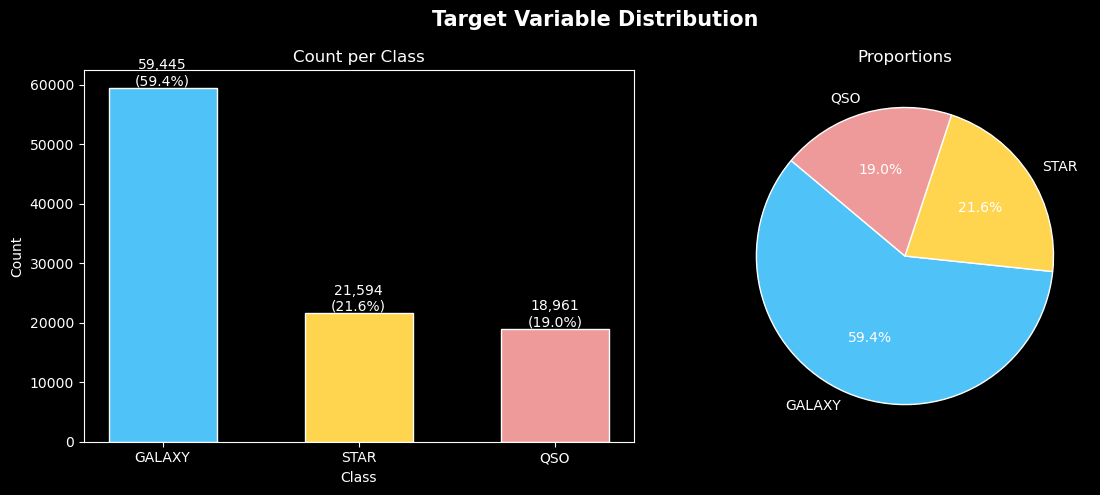

Since there is moderate imbalance detected, macro-F1 chosen as primary metric.


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 3a — Target Distribution
#
# IMPLICATION: Class imbalance (~59%/21%/20%) means accuracy alone is
# misleading. A naive "always predict GALAXY" classifier scores 59% accuracy
# while completely missing stars and quasars. → Macro-F1 is the right metric.
# ─────────────────────────────────────────────────────────────────────────────
counts = df['class'].value_counts()
pcts   = df['class'].value_counts(normalize=True) * 100
colors = [PALETTE.get(c, '#888') for c in counts.index]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Target Variable Distribution', fontsize=15, fontweight='bold')

ax1.bar(counts.index, counts.values, color=colors, edgecolor='white', width=0.55)
for i, (c, p) in enumerate(zip(counts.values, pcts.values)):
    ax1.text(i, c + 400, f'{c:,}\n({p:.1f}%)', ha='center', fontsize=10)
ax1.set_title('Count per Class'); ax1.set_xlabel('Class'); ax1.set_ylabel('Count')

ax2.pie(counts.values, labels=counts.index, colors=colors,
        autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})
ax2.set_title('Proportions')

plt.tight_layout()
plt.savefig('eda_target.png', dpi=150, bbox_inches='tight')
plt.show()
print('Since there is moderate imbalance detected, macro-F1 chosen as primary metric.')

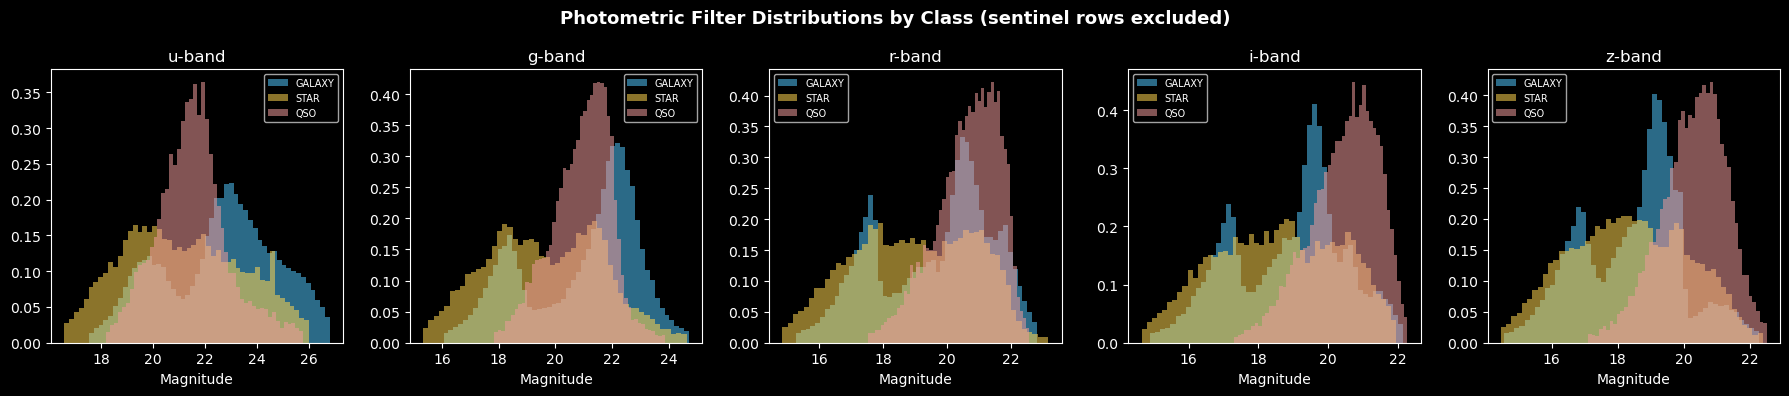

🔍 Raw filter magnitudes overlap heavily across classes.
   → Colour indices (filter differences) will be engineered in Section 7.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 3b — Photometric Filter Distributions
# ─────────────────────────────────────────────────────────────────────────────
# NOTE: We exclude sentinel values (-9999) from these plots to avoid compressing
# the x-axis. Those rows will be removed in data preparation (Section 4).
df_plot = df[(df[['u','g','r','i','z']] > -100).all(axis=1)]

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
fig.suptitle('Photometric Filter Distributions by Class (sentinel rows excluded)',
             fontsize=13, fontweight='bold')
for ax, feat in zip(axes, ['u', 'g', 'r', 'i', 'z']):
    for cls, color in PALETTE.items():
        sub = df_plot[df_plot['class'] == cls][feat]
        # Clip at 1st/99th percentile for visual clarity only
        sub = sub[(sub > sub.quantile(0.01)) & (sub < sub.quantile(0.99))]
        ax.hist(sub, bins=50, alpha=0.55, label=cls, color=color, density=True)
    ax.set_title(f'{feat}-band'); ax.set_xlabel('Magnitude'); ax.legend(fontsize=7)
plt.tight_layout()
plt.savefig('eda_filters.png', dpi=150, bbox_inches='tight')
plt.show()
print('🔍 Raw filter magnitudes overlap heavily across classes.')
print('   → Colour indices (filter differences) will be engineered in Section 7.')

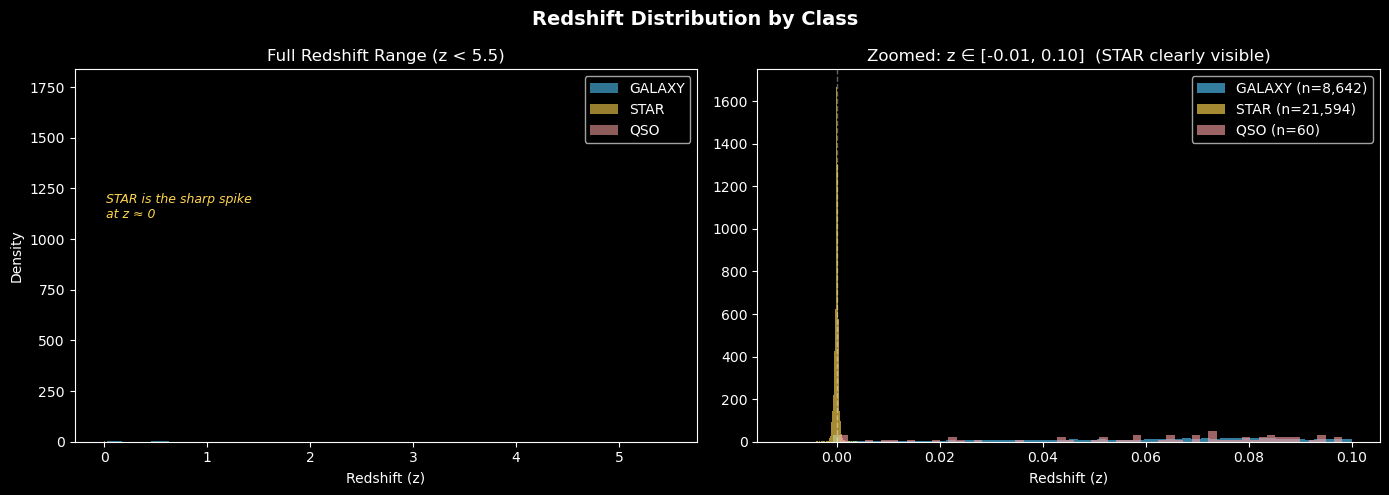

Redshift summary per class:
  GALAXY    min=-0.00997  median=0.45627  max=1.9955
  STAR      min=-0.00414  median=-0.00008  max=0.0042
  QSO       min=0.00046  median=1.61723  max=7.0112

✅ STAR redshift range is [-0.004, +0.004] — 20,828 of 21,594 stars
   have |z| < 0.001. This extreme concentration is physically correct:
   stars are within the Milky Way and have near-zero cosmological redshift.

⚠️  Redshift boundary overlap with STAR range [-0.00414, 0.00415]:
   GALAXY observations inside STAR z-range: 506
   QSO observations inside STAR z-range   : 3
   → These are the observations the model must rely on OTHER features
     (colour indices) to correctly classify, explaining why STAR
     precision is very high (~1.00) but not genuinely perfect.


In [9]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 3c — Redshift Distribution
#
# Star redshift values are tightly clustered in the range [-0.004, +0.004].
# When the previous code applied .quantile(0.99) as an upper clip, it cut the
# histogram at different limits per class:
#   GALAXY q99 ≈ 1.06   (wide range shown)
#   QSO    q99 ≈ 5.28   (wide range shown)
#   STAR   q99 ≈ 0.001  (only the tiniest sliver plotted at 0 on the x-axis)
#
# When galaxy/QSO x-axes span 0–5, the STAR bars at z≈0 are so narrow that
# they appear invisible — the density is real but occupies <<1% of x-axis width.
#
# FIX: Use a FIXED clip value (e.g. z < 5.5) applied equally to all classes,
# AND add a separate zoomed-in panel specifically for STAR to make it visible.
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Redshift Distribution by Class', fontsize=14, fontweight='bold')

# ── Panel 1: Full range (GALAXY + QSO visible; STAR appears as spike at 0)
for cls, color in PALETTE.items():
    sub = df[df['class'] == cls]['redshift']
    sub = sub[sub < 5.5]   # Fixed clip — same threshold for all classes
    axes[0].hist(sub, bins=100, alpha=0.6, label=cls, color=color, density=True)
axes[0].set_title('Full Redshift Range (z < 5.5)')
axes[0].set_xlabel('Redshift (z)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].annotate('STAR is the sharp spike\nat z ≈ 0', xy=(0.02, axes[0].get_ylim()[1]*0.6),
                 color='#FFD54F', fontsize=9, style='italic')

# ── Panel 2: Zoomed in to z ∈ [-0.01, 0.1] — STAR is now clearly visible
for cls, color in PALETTE.items():
    sub = df[df['class'] == cls]['redshift']
    sub = sub[(sub >= -0.01) & (sub <= 0.1)]
    if len(sub) > 0:
        axes[1].hist(sub, bins=60, alpha=0.65, label=f'{cls} (n={len(sub):,})',
                     color=color, density=True)
axes[1].set_title('Zoomed: z ∈ [-0.01, 0.10]  (STAR clearly visible)')
axes[1].set_xlabel('Redshift (z)')
axes[1].legend()
axes[1].axvline(0, color='white', linestyle='--', alpha=0.4, linewidth=1)

plt.tight_layout()
plt.savefig('eda_redshift.png', dpi=150, bbox_inches='tight')
plt.show()

print('Redshift summary per class:')
for cls in ['GALAXY', 'STAR', 'QSO']:
    s = df[df['class'] == cls]['redshift']
    print(f'  {cls:<8}  min={s.min():.5f}  median={s.median():.5f}  max={s.max():.4f}')
print()
print('✅ STAR redshift range is [-0.004, +0.004] — 20,828 of 21,594 stars')
print('   have |z| < 0.001. This extreme concentration is physically correct:')
print('   stars are within the Milky Way and have near-zero cosmological redshift.')
print()
# Report the overlap: how many GALAXY/QSO fall inside the STAR redshift range?
star_z = df[df['class']=='STAR']['redshift']
s_min, s_max = star_z.min(), star_z.max()
gal_overlap = ((df[df['class']=='GALAXY']['redshift'] >= s_min) &
               (df[df['class']=='GALAXY']['redshift'] <= s_max)).sum()
qso_overlap = ((df[df['class']=='QSO']['redshift']    >= s_min) &
               (df[df['class']=='QSO']['redshift']    <= s_max)).sum()
print(f'⚠️  Redshift boundary overlap with STAR range [{s_min:.5f}, {s_max:.5f}]:')
print(f'   GALAXY observations inside STAR z-range: {gal_overlap}')
print(f'   QSO observations inside STAR z-range   : {qso_overlap}')
print(f'   → These are the observations the model must rely on OTHER features')
print(f'     (colour indices) to correctly classify, explaining why STAR')
print(f'     precision is very high (~1.00) but not genuinely perfect.')

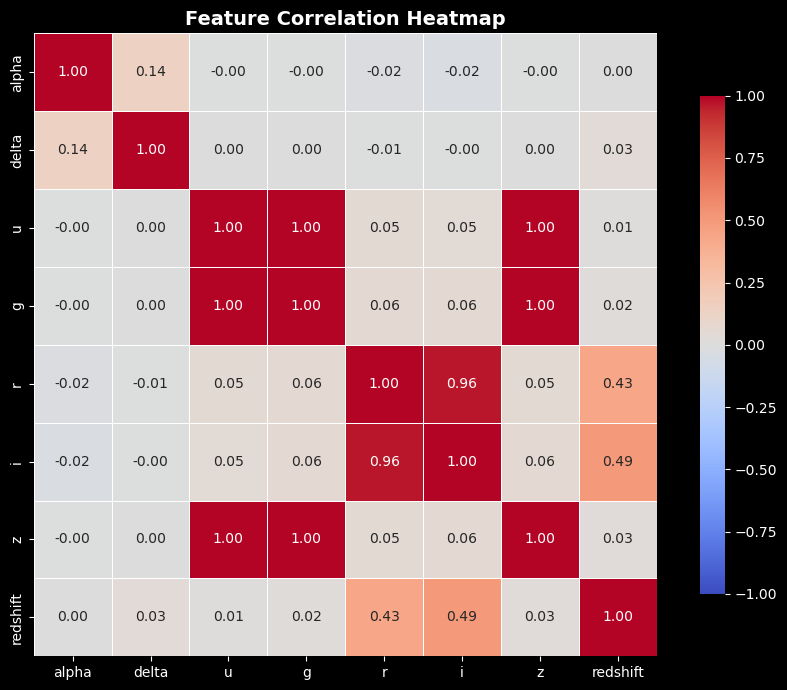

🔍 g, r, i, z are highly correlated (r > 0.93) — redundant.
   alpha, delta show ~0 correlation with other features → likely noise.


In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 3d — Correlation Heatmap
#
# High correlations between g, r, i, z indicate redundant information.
# Colour indices (differences) will address this in feature engineering.
# alpha/delta near-zero correlations with everything confirms they are noise.
# ─────────────────────────────────────────────────────────────────────────────
num_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']
corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax,
            linewidths=0.5, vmin=-1, vmax=1, square=True, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_correlation.png', dpi=150, bbox_inches='tight')
plt.show()
print('🔍 g, r, i, z are highly correlated (r > 0.93) — redundant.')
print('   alpha, delta show ~0 correlation with other features → likely noise.')

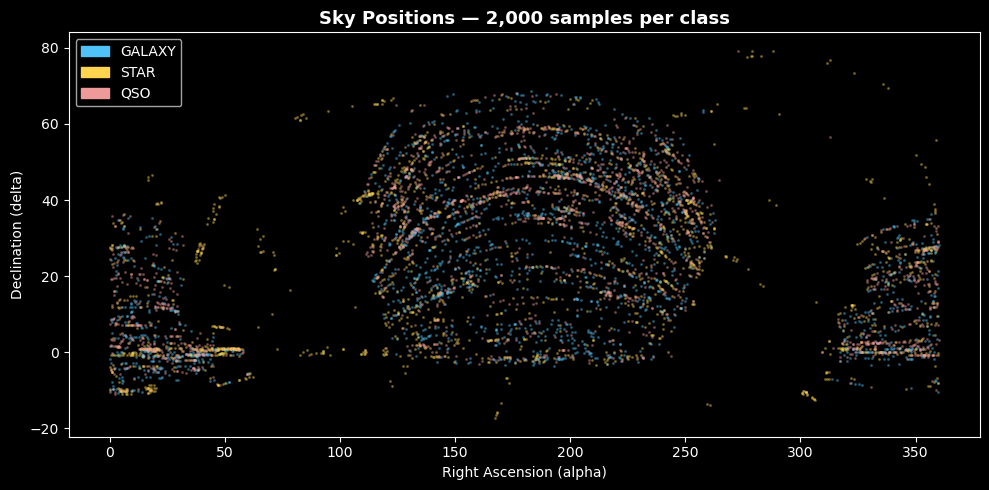

🔍 No spatial class clustering detected.
   → alpha and delta will be dropped in feature engineering (Section 7).


In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 3e — Sky Position Plot
#
# If classes cluster spatially, alpha/delta would add predictive value.
# If they are uniformly mixed, spatial features are noise.
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
for cls, color in PALETTE.items():
    sub = df[df['class'] == cls].sample(2000, random_state=RANDOM_STATE)
    ax.scatter(sub['alpha'], sub['delta'], s=1.5, alpha=0.3, color=color, label=cls)
handles = [mpatches.Patch(color=v, label=k) for k, v in PALETTE.items()]
ax.legend(handles=handles)
ax.set_title('Sky Positions — 2,000 samples per class', fontsize=13, fontweight='bold')
ax.set_xlabel('Right Ascension (alpha)'); ax.set_ylabel('Declination (delta)')
plt.tight_layout()
plt.savefig('eda_sky.png', dpi=150, bbox_inches='tight')
plt.show()
print('🔍 No spatial class clustering detected.')
print('   → alpha and delta will be dropped in feature engineering (Section 7).')

---
## Section 4: Data Preparation

In [12]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 4a Pt1 — Drop Identifier and Leakage Columns
#
# Dropped columns and rationale:
#   obj_ID, run_ID, rerun_ID, cam_col, field_ID, plate, MJD, fiber_ID
#     → All are purely observational bookkeeping with no physical meaning.
#
#   spec_obj_ID → DATA LEAKAGE: dataset documentation explicitly states that
#     two observations sharing spec_obj_ID always belong to the same class.
# ─────────────────────────────────────────────────────────────────────────────
ID_COLS = ['obj_ID', 'run_ID', 'rerun_ID', 'cam_col',
           'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID']

df_clean = df.drop(columns=ID_COLS).copy()
df_clean = df_clean.drop_duplicates()
n0 = len(df_clean)
print(f'Columns retained: {list(df_clean.columns)}')
print(f'Clean shape: {df_clean.shape}')

Columns retained: ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift']
Clean shape: (100000, 9)


In [13]:
#─────────────────────────────────────────────────────────────────────────────
# SECTION 4a Pt2 — Remove Sentinel Values (-9999) and Duplicates
#
# Sentinel values are NOT genuine astronomical outliers — they are data quality flags.
# Including them would:
#   1. Produce wildly incorrect colour indices (e.g. u - g = -9999 - 20 = -10019)
#   2. Force models to learn an artificial 'boundary' at -9999 that does not
#      exist in any real observation.
#   3. Introduce extreme outliers that mislead the model.
#
# GENUINE photometric outliers (e.g. unusually faint/bright objects) should NOT be removed because:
#   - They represent real astronomical objects at the extremes of the survey.
#   - Random Forest is robust to outliers (tree splits are order-based, not
#     distance-based, so extreme values do not disproportionately influence splits).
#   - Removing them would bias the model toward 'average' objects and reduce
#     performance on faint/extreme sources, which are often the most scientifically
#     interesting (e.g. the highest-redshift quasars).
# ─────────────────────────────────────────────────────────────────────────────
mask_sentinel = (df_clean[['u', 'g', 'r', 'i', 'z']] > -100).all(axis=1)
df_clean = df_clean[mask_sentinel].drop_duplicates().reset_index(drop=True)

n_removed = n0 - len(df_clean)
print(f'Rows removed (sentinel/duplicate): {n_removed}')
print(f'Clean dataset shape: {df_clean.shape}')
print(f'\n✅ Only sentinel rows removed. Genuine photometric extremes retained:')
print(f'   RF is order-based and robust to extreme values in genuine observations.')

Rows removed (sentinel/duplicate): 1
Clean dataset shape: (99999, 9)

✅ Only sentinel rows removed. Genuine photometric extremes retained:
   RF is order-based and robust to extreme values in genuine observations.


In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 4b — Encode Target
#
# LabelEncoder maps alphabetically: GALAXY→0, QSO→1, STAR→2
# The encoder is saved for export alongside the model so the Streamlit app
# can decode numeric predictions back to human-readable names.
# ─────────────────────────────────────────────────────────────────────────────
le = LabelEncoder()
df_clean['class_encoded'] = le.fit_transform(df_clean['class'])
CLASS_NAMES = list(le.classes_)
print('Label encoding:', dict(zip(CLASS_NAMES, range(len(CLASS_NAMES)))))

Label encoding: {'GALAXY': 0, 'QSO': 1, 'STAR': 2}


In [15]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 4c — Train / Test Split (80 / 20, stratified)
#
# Baseline features: alpha, delta, u, g, r, i, z, redshift
# 20% test = 20,000 samples → stable metric estimates.
# stratify=y preserves class proportions in both splits.
# ─────────────────────────────────────────────────────────────────────────────
BASELINE_FEATS = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']
TARGET = 'class_encoded'

X = df_clean[BASELINE_FEATS]
y = df_clean[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print(f'Train: {X_train.shape[0]:,}  |  Test: {X_test.shape[0]:,}')
print(f'\nClass distribution in training set:')
for i, cls in enumerate(CLASS_NAMES):
    cnt = (y_train == i).sum()
    print(f'  {cls}: {cnt:,} ({cnt/len(y_train)*100:.1f}%)')

Train: 79,999  |  Test: 20,000

Class distribution in training set:
  GALAXY: 47,556 (59.4%)
  QSO: 15,169 (19.0%)
  STAR: 17,274 (21.6%)


---
## Section 5: Modelling

In [16]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 5 — Train Three Distinct Algorithms
#
# MODEL 1: Logistic Regression — linear baseline
# MODEL 2: Random Forest       — non-linear ensemble (expected best)
# MODEL 3: Gradient Boosting   — sequential ensemble (comparison)
#
# All models use class_weight='balanced' to offset the ~59/21/20 imbalance.
# ─────────────────────────────────────────────────────────────────────────────

print('[1/3] Training Logistic Regression...')
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced',
                               multi_class='multinomial', solver='lbfgs',
                               random_state=RANDOM_STATE))
])
lr_pipe.fit(X_train, y_train)
print('✅ Done.')

print('[2/3] Training Random Forest...')
rf_model = RandomForestClassifier(
    n_estimators=100, class_weight='balanced',
    random_state=RANDOM_STATE, n_jobs=-1
)
rf_model.fit(X_train, y_train)
print('✅ Done.')

print('[3/3] Training Gradient Boosting...')
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=4,
    subsample=0.8, random_state=RANDOM_STATE
)
gb_model.fit(X_train, y_train)
print('✅ Done.')

[1/3] Training Logistic Regression...
✅ Done.
[2/3] Training Random Forest...
✅ Done.
[3/3] Training Gradient Boosting...
✅ Done.


---
## Section 6: Model Evaluation


  MODEL : Logistic Regression
  Train Macro-F1 : 0.9348
  Test  Macro-F1 : 0.9377   ← PRIMARY METRIC
  Test  Accuracy : 0.9437
  Generalisation gap (Train−Test F1): -0.0029  ✅ Acceptable generalisation
────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

      GALAXY       0.98      0.93      0.95     11889
         QSO       0.88      0.93      0.90      3792
        STAR       0.92      1.00      0.96      4319

    accuracy                           0.94     20000
   macro avg       0.93      0.95      0.94     20000
weighted avg       0.95      0.94      0.94     20000



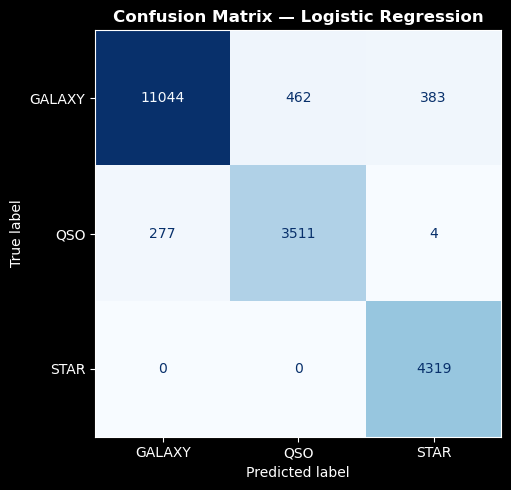


  MODEL : Random Forest (baseline)
  Train Macro-F1 : 1.0000
  Test  Macro-F1 : 0.9756   ← PRIMARY METRIC
  Test  Accuracy : 0.9790
  Generalisation gap (Train−Test F1): 0.0244  ✅ Acceptable generalisation
────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.97      0.93      0.95      3792
        STAR       0.99      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000



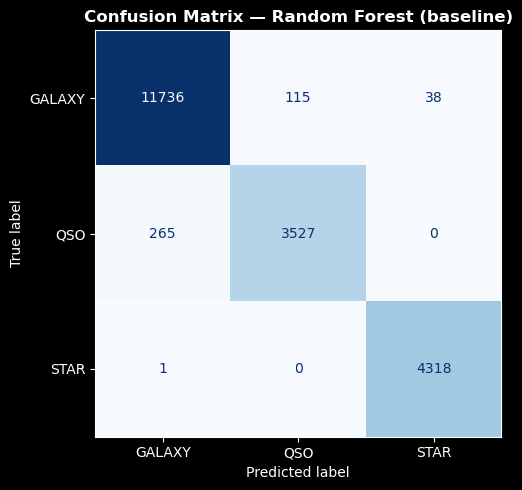


  MODEL : Gradient Boosting (baseline)
  Train Macro-F1 : 0.9760
  Test  Macro-F1 : 0.9736   ← PRIMARY METRIC
  Test  Accuracy : 0.9775
  Generalisation gap (Train−Test F1): 0.0024  ✅ Acceptable generalisation
────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11889
         QSO       0.96      0.92      0.94      3792
        STAR       1.00      1.00      1.00      4319

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



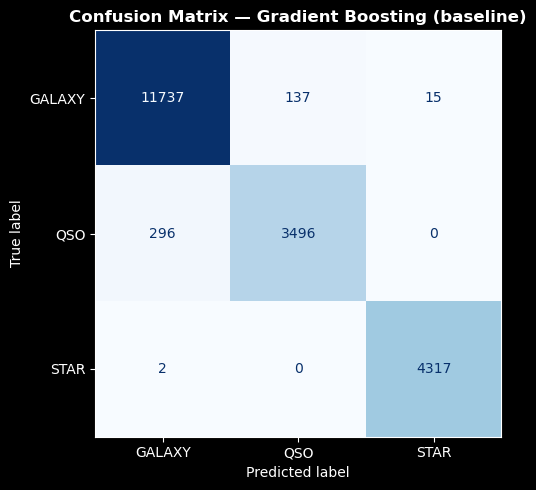

(0.9760031435933715, 0.9736362824414743, 0.9775)

In [17]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 6a — Evaluation Helper
# Reports accuracy, macro-F1, train-vs-test gap (overfitting check),
# classification report, and confusion matrix.
# ─────────────────────────────────────────────────────────────────────────────
all_results = {}

def evaluate_model(model, X_tr, y_tr, X_te, y_te, name):
    """Evaluate model on both train and test to detect overfitting/underfitting."""
    y_pred_train = model.predict(X_tr)
    y_pred_test  = model.predict(X_te)

    train_f1 = f1_score(y_tr, y_pred_train, average='macro')
    test_f1  = f1_score(y_te, y_pred_test,  average='macro')
    test_acc = accuracy_score(y_te, y_pred_test)
    gap      = train_f1 - test_f1

    print(f'\n{"="*60}')
    print(f'  MODEL : {name}')
    print(f'{"="*60}')
    print(f'  Train Macro-F1 : {train_f1:.4f}')
    print(f'  Test  Macro-F1 : {test_f1:.4f}   ← PRIMARY METRIC')
    print(f'  Test  Accuracy : {test_acc:.4f}')
    print(f'  Generalisation gap (Train−Test F1): {gap:.4f}', end='  ')
    if gap > 0.05:
        print('⚠️  OVERFITTING: model memorises training data')
    elif test_f1 < 0.85:
        print('⚠️  UNDERFITTING: model too simple for this problem')
    else:
        print('✅ Acceptable generalisation')
    print(f'{"─"*60}')
    print(classification_report(y_te, y_pred_test, target_names=CLASS_NAMES))

    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay(
        confusion_matrix(y_te, y_pred_test), display_labels=CLASS_NAMES
    ).plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(f'Confusion Matrix — {name}', fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'cm_{name.replace(" ","_")}.png', dpi=150, bbox_inches='tight')
    plt.show()

    all_results[name] = {
        'Train F1': round(train_f1, 4),
        'Test F1' : round(test_f1, 4),
        'Test Acc': round(test_acc, 4),
        'Gap'     : round(gap, 4)
    }
    return train_f1, test_f1, test_acc

evaluate_model(lr_pipe,  X_train, y_train, X_test, y_test, 'Logistic Regression')
evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'Random Forest (baseline)')
evaluate_model(gb_model, X_train, y_train, X_test, y_test, 'Gradient Boosting (baseline)')

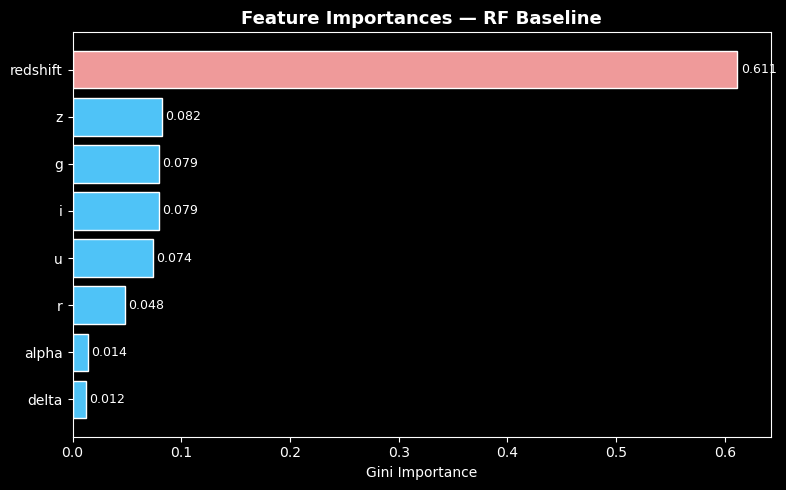

redshift    0.611463
z           0.082168
g           0.079337
i           0.079251
u           0.073581
r           0.047997
alpha       0.013865
delta       0.012338

✅ redshift dominates which confirms EDA. alpha & delta near-zero → confirm dropping them.


In [18]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 6b — Feature Importance (Random Forest Baseline)
# Gini importance confirms or challenges EDA observations.
# ─────────────────────────────────────────────────────────────────────────────
importances = pd.Series(
    rf_model.feature_importances_, index=BASELINE_FEATS
).sort_values()

fig, ax = plt.subplots(figsize=(8, 5))
colors_fi = ['#EF9A9A' if v > 0.25 else '#4FC3F7' for v in importances.values]
bars = ax.barh(importances.index, importances.values, color=colors_fi, edgecolor='white')
for bar, val in zip(bars, importances.values):
    ax.text(bar.get_width() + 0.003, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9)
ax.set_xlabel('Gini Importance')
ax.set_title('Feature Importances — RF Baseline', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('feat_importance_baseline.png', dpi=150, bbox_inches='tight')
plt.show()
print(importances.sort_values(ascending=False).to_string())
print('\n✅ redshift dominates which confirms EDA. alpha & delta near-zero → confirm dropping them.')

In [19]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 6c — Overfitting / Underfitting Discussion
#
# sklearn rounds to 2 decimal places in classification_report.
# A value of 1.00 means precision ≥ 0.995, NOT literally 1.0000.
# ─────────────────────────────────────────────────────────────────────────────
print('=== GENERALISATION SUMMARY ===')
gap_df = pd.DataFrame(all_results).T[['Train F1', 'Test F1', 'Gap']]
print(gap_df.to_string())

print()
print('Exact STAR precision:')
from sklearn.metrics import precision_score
for name, (model_, X_tr_, y_tr_, X_te_) in [
    ('RF baseline', (rf_model, X_train, y_train, X_test))
]:
    y_pred_ = model_.predict(X_te_)
    prec = precision_score(y_test, y_pred_, average=None, labels=[0,1,2])
    for i, cls in enumerate(CLASS_NAMES):
        print(f'  {cls}: precision = {prec[i]:.6f}')

=== GENERALISATION SUMMARY ===
                              Train F1  Test F1     Gap
Logistic Regression             0.9348   0.9377 -0.0029
Random Forest (baseline)        1.0000   0.9756  0.0244
Gradient Boosting (baseline)    0.9760   0.9736  0.0024

Exact STAR precision:
  GALAXY: precision = 0.977837
  QSO: precision = 0.968424
  STAR: precision = 0.991276


In [20]:
# ─────────────────────────────────────────────────────────────────────────────
# SECTION 6d — Predict on Mock Observations
#
# Five representative SDSS-like observations to test the baseline RF model.
# Values designed to represent archetypal members of each class.
# ─────────────────────────────────────────────────────────────────────────────
new_obs = pd.DataFrame({
    'alpha': [183.5, 210.0, 330.1, 45.8,  260.3],
    'delta': [0.25,  30.0,  -5.2,  20.1,  -10.5],
    'u':     [20.5,  22.3,  23.1,  18.2,  25.0],
    'g':     [19.8,  21.0,  22.0,  17.5,  23.5],
    'r':     [19.2,  20.5,  21.5,  17.0,  22.8],
    'i':     [18.9,  20.1,  21.0,  16.8,  22.1],
    'z':     [18.6,  19.8,  20.7,  16.5,  21.5],
    'redshift': [0.62, 1.35, 0.0001, 0.0002, 0.85],
})

preds   = le.inverse_transform(rf_model.predict(new_obs))
probas  = rf_model.predict_proba(new_obs)

print(f'{"Obs":<5} {"Redshift":<12} {"Predicted":<10} {"Confidence"}')
print('─' * 45)
for i, (cls, pr, z) in enumerate(zip(preds, probas, new_obs['redshift'])):
    print(f'{i+1:<5} {z:<12.5f} {cls:<10} {max(pr):.3f}')

Obs   Redshift     Predicted  Confidence
─────────────────────────────────────────────
1     0.62000      QSO        0.510
2     1.35000      QSO        0.950
3     0.00010      STAR       0.810
4     0.00020      STAR       0.980
5     0.85000      GALAXY     0.820


---
## Section 7: Iterative Development — Feature Engineering, Selection & Tuning